### Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import median_absolute_error

In [2]:
#global variables
entidade='Barreiro'
D=10 #how many lagged values to consider
tol_width=2 #suggested in paper is 5
window_size=8 #suggested value in the paper is 8
lower_bound_surprises=2 #suggested value in the paper is 2
activate_grid_search=0 #if set to 1 it will optimize the parameters for SVR

# changes according to the dataset
min_date_train='2018-04-01'
max_date_train='2018-06-07'
min_date_predict='2018-06-08'
max_date_predict='2018-06-30'
min_date_detect='2018-06-15'
max_date_detect='2018-06-21'

### Loading data

In [3]:
holidays = pd.read_csv('Holidays.csv',sep=';')

In [4]:
if entidade=='Barreiro':
    sep=';'
    newdate = ['28/06/2018']
if entidade=='Beja':
    sep=','
    newdate = ['10/05/2018']
if entidade=='Infraquinta':
    sep=','
    newdate = ['07/09/2017']
    
holidays.loc[766]= newdate

In [5]:
header = ["date","time","flow","anomaly"]
df = pd.read_csv('Barreiro2018.csv', sep=sep, names=header)

In [6]:
df

,date,time,flow,anomaly
0,01/01/2018,00:07:30,18.333067,0
1,01/01/2018,00:22:30,18.333067,0
2,01/01/2018,00:37:30,19.784872,0
3,01/01/2018,00:52:30,22.294744,0
4,01/01/2018,01:07:30,27.229756,0
...,...,...,...,...
35035,31/12/2018,22:52:30,24.792000,0
35036,31/12/2018,23:07:30,23.029933,0
35037,31/12/2018,23:22:30,20.415628,0
35038,31/12/2018,23:37:30,22.019056,0


In [7]:
df[df['anomaly']==1]

,date,time,flow,anomaly
12400,10/05/2018,04:07:30,18.061694,1
12401,10/05/2018,04:22:30,17.910167,1
12402,10/05/2018,04:37:30,22.092593,1
12403,10/05/2018,04:52:30,22.449994,1
12404,10/05/2018,05:07:30,28.190661,1
...,...,...,...,...
33950,20/12/2018,15:37:30,40.260361,1
33951,20/12/2018,15:52:30,45.555689,1
33952,20/12/2018,16:07:30,46.908672,1
33953,20/12/2018,16:22:30,51.185917,1


In [8]:
df.dtypes

date        object
time        object
flow       float64
anomaly      int64
dtype: object

In [9]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])

In [10]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
time_unique_val

array(['00:07:30', '00:22:30', '00:37:30', '00:52:30', '01:07:30',
       '01:22:30', '01:37:30', '01:52:30', '02:07:30', '02:22:30',
       '02:37:30', '02:52:30', '03:07:30', '03:22:30', '03:37:30',
       '03:52:30', '04:07:30', '04:22:30', '04:37:30', '04:52:30',
       '05:07:30', '05:22:30', '05:37:30', '05:52:30', '06:07:30',
       '06:22:30', '06:37:30', '06:52:30', '07:07:30', '07:22:30',
       '07:37:30', '07:52:30', '08:07:30', '08:22:30', '08:37:30',
       '08:52:30', '09:07:30', '09:22:30', '09:37:30', '09:52:30',
       '10:07:30', '10:22:30', '10:37:30', '10:52:30', '11:07:30',
       '11:22:30', '11:37:30', '11:52:30', '12:07:30', '12:22:30',
       '12:37:30', '12:52:30', '13:07:30', '13:22:30', '13:37:30',
       '13:52:30', '14:07:30', '14:22:30', '14:37:30', '14:52:30',
       '15:07:30', '15:22:30', '15:37:30', '15:52:30', '16:07:30',
       '16:22:30', '16:37:30', '16:52:30', '17:07:30', '17:22:30',
       '17:37:30', '17:52:30', '18:07:30', '18:22:30', '18:37:

In [11]:
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
periods_per_day

96

In [12]:
time_unique_ind=np.arange(periods_per_day)
time_unique_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [13]:
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
time_unique

,time,time_unique_ind
0,00:07:30,0
1,00:22:30,1
2,00:37:30,2
3,00:52:30,3
4,01:07:30,4
...,...,...
91,22:52:30,91
92,23:07:30,92
93,23:22:30,93
94,23:37:30,94


In [14]:
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])
df.head()

,date,time,flow,anomaly,time_ind
0,2018-01-01,00:07:30,18.333067,0,0
1,2018-01-01,00:22:30,18.333067,0,1
2,2018-01-01,00:37:30,19.784872,0,2
3,2018-01-01,00:52:30,22.294744,0,3
4,2018-01-01,01:07:30,27.229756,0,4


In [15]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek
df.head()

,date,time,flow,anomaly,time_ind,dayofweek
0,2018-01-01,00:07:30,18.333067,0,0,0
1,2018-01-01,00:22:30,18.333067,0,1,0
2,2018-01-01,00:37:30,19.784872,0,2,0
3,2018-01-01,00:52:30,22.294744,0,3,0
4,2018-01-01,01:07:30,27.229756,0,4,0


In [16]:
holidays

,date
0,01/01/1970
1,27/03/1970
2,29/03/1970
3,28/05/1970
4,05/10/1970
...,...
760,10/06/2029
761,15/08/2029
762,08/12/2029
763,25/12/2029


In [17]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-05-10


In [18]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

In [19]:
#check if it worked
df[df.date=='2018-06-28']

,date,time,flow,anomaly,time_ind,dayofweek
17088,2018-06-28,00:07:30,28.612822,0,0,-1
17089,2018-06-28,00:22:30,24.398811,0,1,-1
17090,2018-06-28,00:37:30,21.571439,0,2,-1
17091,2018-06-28,00:52:30,22.075917,0,3,-1
17092,2018-06-28,01:07:30,20.597983,0,4,-1
...,...,...,...,...,...,...
17179,2018-06-28,22:52:30,43.099850,0,91,-1
17180,2018-06-28,23:07:30,37.970472,0,92,-1
17181,2018-06-28,23:22:30,37.907072,0,93,-1
17182,2018-06-28,23:37:30,36.773883,0,94,-1


## Lags of time series

### D previous readings

In [20]:
# in order to construct a new dataframe with D lagged values
df_lagged = df.copy()
number_lags = D # this is D (a global variable - check top of notebook)

for i in range(1, number_lags+1):
    shifted = df['flow'].shift(i)
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [21]:
# just to label the columns of the resulting dataframe
lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
df_lagged.columns=colnames
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
0,2018-01-01,00:07:30,18.333067,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,00:22:30,18.333067,0,1,-1,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,00:37:30,19.784872,0,2,-1,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,00:52:30,22.294744,0,3,-1,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,01:07:30,27.229756,0,4,-1,22.294744,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# in order to drop the rows corresponding do the first day
#to get rid of the NaN values

df_lagged =  df_lagged.iloc[periods_per_day:]
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
96,2018-02-01,00:07:30,15.008750,0,0,3,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933,23.194106
97,2018-02-01,00:22:30,13.375950,0,1,3,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933
98,2018-02-01,00:37:30,12.083542,0,2,3,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819
99,2018-02-01,00:52:30,12.161200,0,3,3,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994
100,2018-02-01,01:07:30,25.701713,0,4,3,12.161200,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067


In [23]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

## Create data

In [24]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
    sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data
 

In [25]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-30', 'weekdays', 0)
#data

## GridSearchCV

In [26]:
# to look for the best SVR parameters
'''
to get the best set of parameters for the SVR model
'''
def grid_search(data):
    y=data['flow'].copy()
    X=data.iloc[:,6:] #contains only the D previous values
    # SVR model
    model=svm.SVR()
    # dict of parameters
    parameters={'kernel':['rbf'], 'gamma':['auto','scale'], 'C':[0.1, 1, 10]} # 'epsilon':[0.01,0.05,0.5,1]
    # strategy to evaluate the performance of the cross-validated mode on the test set
    scorer=make_scorer(mean_squared_error, greater_is_better=False)
    # Build and fit the GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=KFold(n_splits=5))
    grid_results = grid.fit(X, y)
    # in order to return the best set of parameters
    best_param=grid_results.cv_results_['params'][grid_results.best_index_]   
    return best_param

## SVR models

In [27]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def svr_model(data,epsilon):
    y=data['flow'].copy()
    X=data.iloc[:,6:] #contains only the D previous values
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    if (activate_grid_search==1):
        params=grid_search(data)
        svr_model = svm.SVR(C=params['C'], epsilon=epsilon, gamma=params['gamma'], kernel=params['kernel'])
    else:
        svr_model = svm.SVR(C=10.0, epsilon=epsilon)
    svr_model.fit(X_train, y_train)
    return svr_model

In [28]:
#just for testing
#svr_model(data)

In [29]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_weekdays(min_date, max_date):
    regressors_weekdays = []
    std_weekdays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        std_weekdays.append(data['flow'].std())
        #epsilon=0.5
        epsilon=data['flow'].std()*0.5 #the tube
        regressors_weekdays.append(svr_model(data, epsilon))
    return regressors_weekdays,std_weekdays


In [30]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_saturdays(min_date, max_date):
    regressors_saturdays = []
    std_saturdays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'saturdays', i)
        std_saturdays.append(data['flow'].std())
        #epsilon=0.5
        epsilon=data['flow'].std()*0.5
        regressors_saturdays.append(svr_model(data, epsilon))
    return regressors_saturdays, std_saturdays



In [31]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_and_std_sundays(min_date, max_date):
    regressors_sundays = []
    std_sundays=[]
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'sundays', i)
        std_sundays.append(data['flow'].std())
        epsilon=data['flow'].std()*0.5
        #epsilon=0.5
        regressors_sundays.append(svr_model(data,epsilon))
    return regressors_sundays, std_sundays

In [32]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

            

In [33]:
# for testing, we will use min_date_train to max_date_train for
# constructing regressors
regressors_weekdays,std_weekdays=creates_regressors_and_std_weekdays(min_date_train, max_date_train)
regressors_saturdays,std_saturdays=creates_regressors_and_std_saturdays(min_date_train, max_date_train)
regressors_sundays, std_sundays=creates_regressors_and_std_weekdays(min_date_train, max_date_train)

In [34]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [35]:
y_true=df2predict['flow']
y_pred=predict_flow(df2predict)
y_pred=np.array(y_pred)

In [36]:
df_final=df2predict[['date','time','time_ind','dayofweek','flow','anomaly']]
df_final.insert(5,'forecast',y_pred)
df_final

,date,time,time_ind,dayofweek,flow,forecast,anomaly
15648,2018-06-13,00:07:30,0,2,18.771094,21.148820,0
15649,2018-06-13,00:22:30,1,2,21.083011,19.859679,0
15650,2018-06-13,00:37:30,2,2,17.107089,19.483355,0
15651,2018-06-13,00:52:30,3,2,18.516683,16.857650,0
15652,2018-06-13,01:07:30,4,2,18.493828,17.678959,0
...,...,...,...,...,...,...,...
32635,2018-06-12,22:52:30,91,1,19.240544,22.698098,0
32636,2018-06-12,23:07:30,92,1,17.913678,20.339616,0
32637,2018-06-12,23:22:30,93,1,15.907861,18.847955,0
32638,2018-06-12,23:37:30,94,1,16.196244,18.714869,0


In [37]:
# to choose what we want to plot in terms of forecast (number of days)
def plot_prediction(df2predict,number_days):   
    y_true=df2predict['flow']
    y_pred=predict_flow(df2predict)
    y_pred=np.array(y_pred)
    period_to_plot=periods_per_day*number_days
    
    yTrue=y_true[0:period_to_plot]
    yPred=y_pred[0:period_to_plot]
    
    period_len=24*60/periods_per_day #i.e., how many minutes per period
    string_xlabel= f"Time (in periods of {period_len} min)"
    string_title=f"Comparing real and predicted values for {number_days} day(s) from {min_date_predict}"
    
    x = np.linspace(0,period_to_plot,period_to_plot) 
    
    plt.plot(x, yTrue, label='Real value',color='blue')
    plt.plot(x, yPred, label='Predicted with SVR',color='orange',linestyle='--') # orange
    plt.xlabel(string_xlabel)
    plt.ylabel('Flow rate ($m^3s^{-1}$)')
    plt.title(string_title)
    plt.legend()
    plt.show()
    
    # evaluation metrics
    # MSE
    mse = mean_squared_error(yTrue, yPred)
    mse = print('MSE from SVR: %.3f' % mse)
    # RMSE
    rmse = mean_squared_error(yTrue, yPred, squared=False)
    rmse = print('RMSE from SVR: %.3f' % rmse)
    # MAE
    mae = mean_absolute_error(yTrue, yPred) # median_absolute_error
    mae = print('MAE from SVR: %.3f' % mae)
    # MAPE
    mape = mean_absolute_error(yTrue, yPred)*100
    mape= print('MAPE from SVR: %.3f' % mape)
    
#    return result

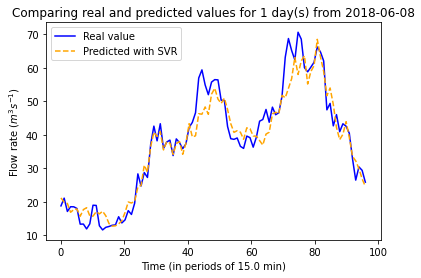

MSE from SVR: 18.963
RMSE from SVR: 4.355
MAPE from SVR: 315.337
MAE from SVR: 2.361


In [38]:
# just to test
predict_1d=plot_prediction(df2predict, 1)

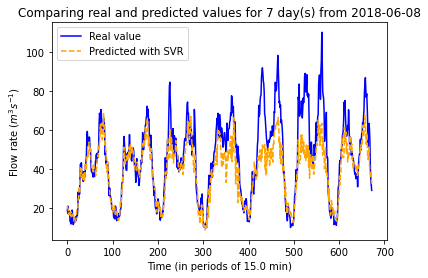

MSE from SVR: 145.159
RMSE from SVR: 12.048
MAPE from SVR: 806.880
MAE from SVR: 4.675


In [39]:
predict_7d=plot_prediction(df2predict, 7)

## Anomaly detection

In [40]:
df_final.head()

,date,time,time_ind,dayofweek,flow,forecast,anomaly
15648,2018-06-13,00:07:30,0,2,18.771094,21.148820,0
15649,2018-06-13,00:22:30,1,2,21.083011,19.859679,0
15650,2018-06-13,00:37:30,2,2,17.107089,19.483355,0
15651,2018-06-13,00:52:30,3,2,18.516683,16.857650,0
15652,2018-06-13,01:07:30,4,2,18.493828,17.678959,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       35040 non-null  datetime64[ns]
 1   time       35040 non-null  object        
 2   flow       35040 non-null  float64       
 3   anomaly    35040 non-null  int64         
 4   time_ind   35040 non-null  int32         
 5   dayofweek  35040 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 1.5+ MB


In [42]:
'''A surprise occurs when the difference
between the observed and predicted value is greater
than 5 times the sd for that period of the day
This function creates a dataframe containing
date,  time, observed flow, predicted flow, a column indicating surprise
tol_width x std_deviation for each period for each type of day
paper suggests tol_width=5
'''
def detect_surprises(df_final, tol_width):
    df=df_final.copy()
    df["surprise"] = ""
    for i in range(len(df_final)):
        time_ind=df.iloc[i,2] # 1
        dayofweek=df.iloc[i,3] # 2
        observed=df.iloc[i,4] # 3
        predicted=df.iloc[i,5] # 4
        difference=abs(observed-predicted)
        if (dayofweek>=0) and (dayofweek <=4): #i.e., a weekday
            if difference>tol_width*std_weekdays[time_ind]:
                df.iloc[i,7]=1 # 6
            else:
                df.iloc[i,7]=0 # 6
        elif (df.iloc[i,6]==5): # i.e. saturdays
            if difference>tol_width*std_saturdays[time_ind]:
                df.iloc[i,7]=1 # 6
            else:
                df.iloc[i,7]=0 # 6
        else: #i.e., sundays
            if difference>tol_width*std_sundays[time_ind]:
                df.iloc[i,7]=1 # 6
            else:
                df.iloc[i,7]=0 # 6
    return df

In [43]:
#tol_width is currently set as a global variable
#suggested value in paper is 5
df_surprises=detect_surprises(df_final,tol_width)
df_surprises

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise
15648,2018-06-13,00:07:30,0,2,18.771094,21.148820,0,0
15649,2018-06-13,00:22:30,1,2,21.083011,19.859679,0,0
15650,2018-06-13,00:37:30,2,2,17.107089,19.483355,0,0
15651,2018-06-13,00:52:30,3,2,18.516683,16.857650,0,0
15652,2018-06-13,01:07:30,4,2,18.493828,17.678959,0,0
...,...,...,...,...,...,...,...,...
32635,2018-06-12,22:52:30,91,1,19.240544,22.698098,0,0
32636,2018-06-12,23:07:30,92,1,17.913678,20.339616,0,0
32637,2018-06-12,23:22:30,93,1,15.907861,18.847955,0,0
32638,2018-06-12,23:37:30,94,1,16.196244,18.714869,0,0


In [44]:
'''
from the dataframe with the detected surprises
we will slide a window of a certain window_size
(paper suggests a size of n=8)
and if in each window a number greater than the 
lower bound for suprises (paper suggests cubic root of n )
we classify the event as anomaly
'''
def detect_anomalies(df_surprises, window_size, lower_bound_surprises):
    df_surprises["detected_anomaly"] = 0
    for i in range(len(df_surprises)-window_size):
        sum=0
        #sliding window
        for j in range(window_size):
            sum+=df_surprises.iloc[i+j,7] #adds all surprises in window -> 6
        if sum>lower_bound_surprises:
            for j in range(window_size):
                if (df_surprises.iloc[i+j,7]==1): # 6
                    df_surprises.iloc[i+j,8]=1 # surprises classified as anomalies -> 7
    return df_surprises

In [45]:
#window_size is a global variable, suggested value in paper is 8
#lower_bound_surprises is a global variable, suggested value in paper is 2
df = detect_anomalies(df_surprises, window_size, lower_bound_surprises)

In [46]:
df[df['surprise']==1]

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15872,2018-06-15,08:07:30,32,4,73.334022,45.459231,0,1,1
15873,2018-06-15,08:22:30,33,4,82.744456,46.505419,0,1,1
15874,2018-06-15,08:37:30,34,4,84.639928,45.914551,0,1,1
15928,2018-06-15,22:07:30,88,4,70.687200,42.550913,0,1,0
15989,2018-06-16,13:22:30,53,5,59.516561,40.847473,0,1,0
...,...,...,...,...,...,...,...,...,...
26757,2018-06-10,17:22:30,69,6,76.233122,42.969528,0,1,1
26758,2018-06-10,17:37:30,70,6,81.006977,50.881860,0,1,1
26762,2018-06-10,18:37:30,74,6,89.106250,50.670867,0,1,1
32601,2018-06-12,14:22:30,57,1,60.568611,25.704399,0,1,0


In [47]:
#print detected anomalies
df[df['detected_anomaly']==1]

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15872,2018-06-15,08:07:30,32,4,73.334022,45.459231,0,1,1
15873,2018-06-15,08:22:30,33,4,82.744456,46.505419,0,1,1
15874,2018-06-15,08:37:30,34,4,84.639928,45.914551,0,1,1
16070,2018-06-17,09:37:30,38,6,72.740467,44.097448,0,1,1
16074,2018-06-17,10:37:30,42,6,77.552097,45.056387,0,1,1
...,...,...,...,...,...,...,...,...,...
26755,2018-06-10,16:52:30,67,6,66.495967,43.872571,0,1,1
26756,2018-06-10,17:07:30,68,6,74.504406,45.813136,0,1,1
26757,2018-06-10,17:22:30,69,6,76.233122,42.969528,0,1,1
26758,2018-06-10,17:37:30,70,6,81.006977,50.881860,0,1,1


In [48]:
# where anomalies and detected anomalies coincide
df[(df['anomaly']==1) & (df['detected_anomaly']==1)]

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
16158,2018-06-18,07:37:30,30,0,75.320662,50.677570,1,1,1
16159,2018-06-18,07:52:30,31,0,83.694817,43.150099,1,1,1
16160,2018-06-18,08:07:30,32,0,67.253861,42.981954,1,1,1
16161,2018-06-18,08:22:30,33,0,70.381694,43.001035,1,1,1
16170,2018-06-18,10:37:30,42,0,77.283161,47.069687,1,1,1
16171,2018-06-18,10:52:30,43,0,87.428539,49.641179,1,1,1
16172,2018-06-18,11:07:30,44,0,89.163186,46.002925,1,1,1
16173,2018-06-18,11:22:30,45,0,86.622922,48.106415,1,1,1
16174,2018-06-18,11:37:30,46,0,79.576678,44.521455,1,1,1
16175,2018-06-18,11:52:30,47,0,83.171094,53.000671,1,1,1


In [49]:
df

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15648,2018-06-13,00:07:30,0,2,18.771094,21.148820,0,0,0
15649,2018-06-13,00:22:30,1,2,21.083011,19.859679,0,0,0
15650,2018-06-13,00:37:30,2,2,17.107089,19.483355,0,0,0
15651,2018-06-13,00:52:30,3,2,18.516683,16.857650,0,0,0
15652,2018-06-13,01:07:30,4,2,18.493828,17.678959,0,0,0
...,...,...,...,...,...,...,...,...,...
32635,2018-06-12,22:52:30,91,1,19.240544,22.698098,0,0,0
32636,2018-06-12,23:07:30,92,1,17.913678,20.339616,0,0,0
32637,2018-06-12,23:22:30,93,1,15.907861,18.847955,0,0,0
32638,2018-06-12,23:37:30,94,1,16.196244,18.714869,0,0,0


In [50]:
def create_data_anomalydetect(min_date,max_date):
    sel_data=df[(df.date>=min_date) & (df.date<=max_date)]
    
    return sel_data

In [51]:
# just to test
df_detect = create_data_anomalydetect(min_date_detect,max_date_detect)
df_detect

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
15840,2018-06-15,00:07:30,0,4,30.787828,29.716065,0,0,0
15841,2018-06-15,00:22:30,1,4,25.339439,30.408102,0,0,0
15842,2018-06-15,00:37:30,2,4,20.429650,28.414210,0,0,0
15843,2018-06-15,00:52:30,3,4,19.745522,23.830954,0,0,0
15844,2018-06-15,01:07:30,4,4,21.049739,19.237775,0,0,0
...,...,...,...,...,...,...,...,...,...
16507,2018-06-21,22:52:30,91,3,37.156211,29.071990,0,0,0
16508,2018-06-21,23:07:30,92,3,28.144594,25.499932,0,0,0
16509,2018-06-21,23:22:30,93,3,24.674050,28.425471,0,0,0
16510,2018-06-21,23:37:30,94,3,24.278594,25.401461,0,0,0


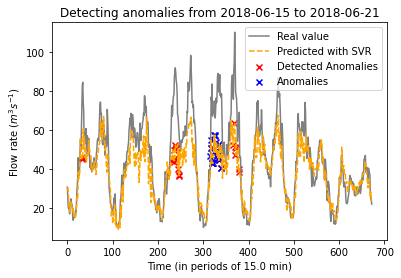

In [52]:

x = np.linspace(0,len(df_detect),len(df_detect)) 

# predicted anomalies
anomalies_x =[]
anomalies_y=[]
# real anomalies
anomalies_z=[]
anomalies_w=[]
  
for i in range(0, len(df_detect)):
    if df_detect.iloc[i,8]==1:#i.e., a detected anomaly
        anomalies_x.append(i)
        anomalies_y.append(df_detect.iloc[i,5]) #predicted value
        
for i in range(0, len(df_detect)): 
    if df_detect.iloc[i,6]==1:#i.e., a anomaly
        anomalies_z.append(i)
        anomalies_w.append(df_detect.iloc[i,5]) #predicted value
        
period_len=24*60/periods_per_day #i.e., how many minutes per period
string_xlabel= f"Time (in periods of {period_len} min)"
        
plt.plot(x, df_detect['flow'], label='Real value',color='grey')
plt.plot(x, df_detect['forecast'], label='Predicted with SVR',color='orange',linestyle='--')
plt.xlabel(string_xlabel)
plt.ylabel('Flow rate ($m^3s^{-1}$)')

plt.scatter(anomalies_x, anomalies_y,marker='x', color='red', label='Detected Anomalies')
plt.scatter(anomalies_z, anomalies_w,marker='x', color='blue', label='Anomalies')
string_title=f"Detecting anomalies from {min_date_detect} to {max_date_detect}"
#string_title=f"Detecting anomalies for {number_days} day(s) from {min_date_detect} to {max_date_detect}"
plt.title(string_title)
plt.legend()
plt.show()

In [54]:
day_anomaly='2018-06-18'

In [58]:
df_anomaly = df_detect[df_detect['date']==day_anomaly]
df_anomaly

,date,time,time_ind,dayofweek,flow,forecast,anomaly,surprise,detected_anomaly
16128,2018-06-18,00:07:30,0,0,25.426900,25.438974,0,0,0
16129,2018-06-18,00:22:30,1,0,22.876667,30.968811,0,0,0
16130,2018-06-18,00:37:30,2,0,18.489000,25.106495,0,0,0
16131,2018-06-18,00:52:30,3,0,18.695533,21.562608,0,0,0
16132,2018-06-18,01:07:30,4,0,16.597811,17.548703,0,0,0
...,...,...,...,...,...,...,...,...,...
16219,2018-06-18,22:52:30,91,0,69.205878,40.136700,0,1,1
16220,2018-06-18,23:07:30,92,0,45.877817,38.468315,0,0,0
16221,2018-06-18,23:22:30,93,0,46.393211,35.994702,0,0,0
16222,2018-06-18,23:37:30,94,0,45.604622,35.973001,0,0,0


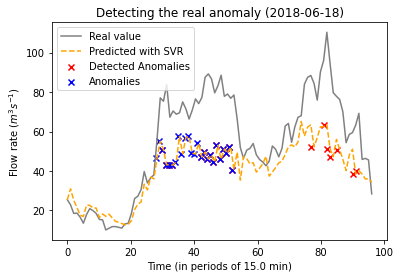

In [59]:

x = np.linspace(0,len(df_anomaly),len(df_anomaly)) 

# predicted anomalies
anomalies_x =[]
anomalies_y=[]
# real anomalies
anomalies_z=[]
anomalies_w=[]
  
for i in range(0, len(df_anomaly)):
    if df_anomaly.iloc[i,8]==1:#i.e., a detected anomaly
        anomalies_x.append(i)
        anomalies_y.append(df_anomaly.iloc[i,5]) #predicted value
        
for i in range(0, len(df_anomaly)): 
    if df_anomaly.iloc[i,6]==1:#i.e., a anomaly
        anomalies_z.append(i)
        anomalies_w.append(df_anomaly.iloc[i,5]) #predicted value
        
period_len=24*60/periods_per_day #i.e., how many minutes per period
string_xlabel= f"Time (in periods of {period_len} min)"
        
plt.plot(x, df_anomaly['flow'], label='Real value',color='grey')
plt.plot(x, df_anomaly['forecast'], label='Predicted with SVR',color='orange',linestyle='--')
plt.xlabel(string_xlabel)
plt.ylabel('Flow rate ($m^3s^{-1}$)')

plt.scatter(anomalies_x, anomalies_y,marker='x', color='red', label='Detected Anomalies')
plt.scatter(anomalies_z, anomalies_w,marker='x', color='blue', label='Anomalies')
string_title=f"Detecting the real anomaly ({day_anomaly})"
#string_title=f"Detecting anomalies for {number_days} day(s) from {min_date_detect} to {max_date_detect}"
plt.title(string_title)
plt.legend()
plt.show()

### Evaluation metrics

In [56]:
def evaluation(df):
    real_anomaly=len(df[df['anomaly']==1].index)
    detected_anomaly=len(df[df['detected_anomaly']==1].index)
    TP = len(df[(df['anomaly']==1) & (df['detected_anomaly']==1)].index)
    FP = len(df[(df['anomaly']==0) & (df['detected_anomaly']==1)].index)
    TN = len(df[(df['anomaly']==0) & (df['detected_anomaly']==0)].index)
    FN = len(df[(df['anomaly']==1) & (df['detected_anomaly']==0)].index)
    
    print('There are',real_anomaly,'occurrences of anomaly.')
    print(detected_anomaly, 'anomalies were detected.')
    print('Confusion Matrix')
    print('True Positives:', TP)
    print('False Positives:', FP)
    print('True Negatives:', TN)
    print('False Negatives:', FN)
    
    accuracy = (TP+TN)/(TP+TN+FN+FP)
    if TP+FN==0:
        recall=TP # or sensitivity or true positive rate
    else:
        recall = TP/(TP+FN)
        
    precision=TP/(TP+FP)
    
    # specificity
    #spec = TN/(TN+FP)
    # false positive rate = 1 - spec
    
    print('Model performance')
    print('Accuracy:',"%.2f" %accuracy)
    print('Recall:',"%.2f" %recall)
    print('Precision:',"%.2f" %precision)
    
    if recall+precision == 0:
        print('There are not any True Positives.')
    else:
        F1_score = (2*precision*recall)/(precision+recall)
        print('F1 score:',"%.2f" %F1_score)
    
#    print('Model performance')
#    print('Accuracy:',"%.2f" %accuracy)
#   print('Recall:',"%.2f" %recall)
#    print('Precision:',"%.2f" %precision)
#   print('F1 score:',"%.2f" %F1_score)

In [57]:
evaluation(df)

There are 25 occurrences of anomaly.
101 anomalies were detected.
Confusion Matrix
True Positives: 19
False Positives: 82
True Negatives: 2101
False Negatives: 6
Model performance
Accuracy: 0.96
Recall: 0.76
Precision: 0.19
F1 score: 0.30


In [67]:
# racio acerto
#RA = detected_anomaly/real_anomaly
#RA

3.92

In [68]:
# racio não deteçoes -> falhas?
#RF = FN/real_anomaly
#RF

0.44